In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from alexnet import AlexNet
from lenet5 import LeNet5
from data_loading import DataLoaderCreator
import re


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
def load_model(model, model_path, dropout_rate=0, init_type='random'):
    """Loads a model from a specified path and initializes it with given parameters"""
    if model == 'alexnet':
        model = AlexNet(dropout_rate=dropout_rate, init_type=init_type)
    elif model == 'lenet5':
        model = LeNet5(dropout_rate=dropout_rate, init_type=init_type)
    else:
        raise ValueError("Invalid model name")
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # CPU/GPU
    model.eval()
    return model

In [40]:
def evaluate_model(model, test_loader, device):
    """
    Evaluates the model on a given test dataset and computes accuracy, precision, recall, and F1-score.

    Parameters:
    - model: PyTorch model to evaluate.
    - test_loader: DataLoader containing the test dataset.
    - device: The device (CPU or GPU) to use for evaluation.

    Returns:
    - A dictionary containing accuracy, precision, recall, and F1-score.
    """
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100

    precision = precision_score(all_labels, all_preds, average='macro') * 100
    recall = recall_score(all_labels, all_preds, average='macro') * 100
    f1 = f1_score(all_labels, all_preds, average='macro') * 100

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

In [41]:
def evaluate_models(model_paths, test_loader, device, model_name):
    """
    Evaluates multiple models and computes mean and standard deviation for accuracy, precision, recall, and F1-score.

    Parameters:
    - model_paths: List of paths to model files.
    - test_loader: DataLoader containing the test dataset.
    - device: The device (CPU or GPU) to use for evaluation.
    - model_name: The name of the model being evaluated.

    Returns:
    - Dictionary with mean and standard deviation for accuracy, precision, recall, and F1-score.
    """
    metrics = {"accuracy": [], "precision": [], "recall": [], "f1_score": []}

    for model_path in model_paths:
        print(f"Evaluating {model_path} ({model_name})...")
        model = load_model("alexnet", model_path, dropout_rate=0, init_type='random')
        results = evaluate_model(model, test_loader, device)

        for key in metrics.keys():
            metrics[key].append(results[key])

        print(f"Accuracy: {results['accuracy']:.2f}%, Precision: {results['precision']:.2f}%, Recall: {results['recall']:.2f}%, F1: {results['f1_score']:.2f}%")

    final_results = {metric: (np.mean(values), np.std(values, ddof=1)) for metric, values in metrics.items()}

    return final_results

In [42]:
def load_loss_data(pattern):
    """Function for loading loss"""
    csv_files = glob.glob(pattern)
    all_data = []

    for file in csv_files:
        match = re.search(r"seed_(\d+)", file)
        seed = int(match.group(1))
        df = pd.read_csv(file, names=["train_loss", "valid_loss"], header=0)
        df["epoch"] = df.index
        df["seed"] = seed
        all_data.append(df)

    df_all = pd.concat(all_data)

    df_grouped = df_all.groupby("epoch").agg(
        train_loss_mean=("train_loss", "mean"),
        train_loss_std=("train_loss", "std"),
        valid_loss_mean=("valid_loss", "mean"),
        valid_loss_std=("valid_loss", "std")
    ).reset_index()

    return df_grouped


In [43]:
def plot_loss(df, model_name, train_color, valid_color, plot_train=True, plot_valid=True):
    """
    Function for plotting loss values.

    Parameters:
    - df: DataFrame containing loss values
    - model_name: Model name printed on legend (e.g., 'Random Flipping')
    - lr: Learning rate value
    - train_color: Color for train loss
    - valid_color: Color for validation loss
    - plot_train: Whether to plot train loss (default: True)
    - plot_valid: Whether to plot validation loss (default: True)
"""

    if plot_train:
        train_label = f"Train Loss: {model_name}"
        plt.plot(df["epoch"], df["train_loss_mean"], label=train_label, color=train_color)
        plt.fill_between(df["epoch"],
                         df["train_loss_mean"] - df["train_loss_std"],
                         df["train_loss_mean"] + df["train_loss_std"],
                         color=train_color, alpha=0.2)

    if plot_valid:
        valid_label = f"Valid Loss: {model_name}"
        plt.plot(df["epoch"], df["valid_loss_mean"], label=valid_label, color=valid_color)
        plt.fill_between(df["epoch"],
                         df["valid_loss_mean"] - df["valid_loss_std"],
                         df["valid_loss_mean"] + df["valid_loss_std"],
                         color=valid_color, alpha=0.2)

Alexnet - Data Augmentation

In [44]:
loader_creator = DataLoaderCreator(seed=123)
test_loader = loader_creator.create_data_loader('cinic-10/test', batch_size=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

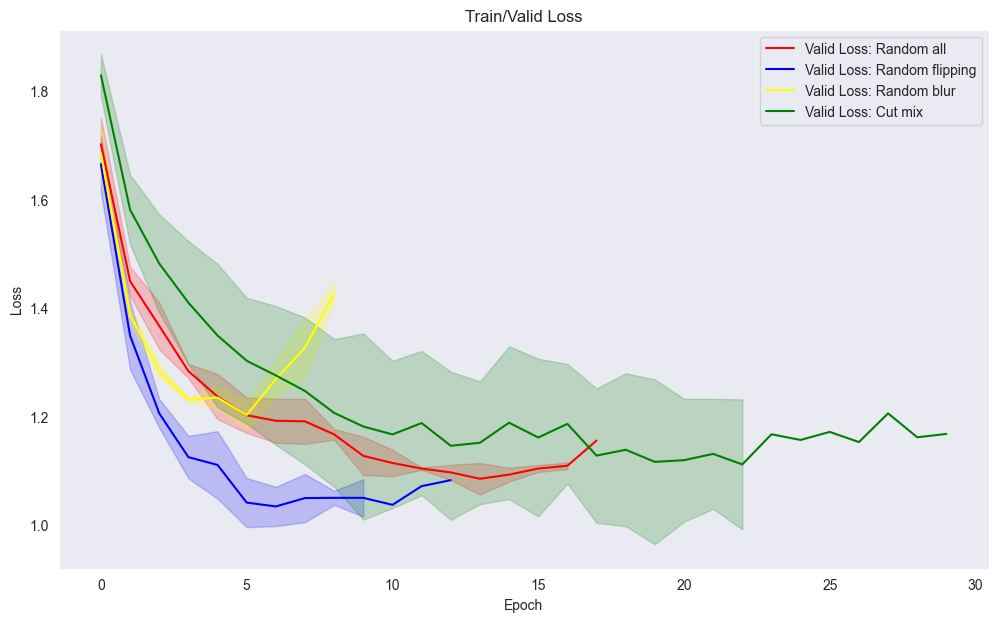

In [45]:
df_alexnet_ra = load_loss_data("saved_losses/alexnet_random_all_seed_*.csv")
df_alexnet_rf = load_loss_data("saved_losses/alexnet_random_flipping_seed_*.csv")
df_alexnet_rb = load_loss_data("saved_losses/alexnet_random_blur_seed_*.csv")
df_alexnet_cm = load_loss_data("saved_losses/alexnet_cut_mix_seed_*.csv")

plt.figure(figsize=(12, 7))

plot_loss(df_alexnet_ra, "Random all", train_color="blue", valid_color="red", plot_train=False)
plot_loss(df_alexnet_rf, "Random flipping", train_color="blue", valid_color="blue", plot_train=False)
plot_loss(df_alexnet_rb, "Random blur", train_color="blue", valid_color="yellow", plot_train=False)
plot_loss(df_alexnet_cm, "Cut mix", train_color="blue", valid_color="green", plot_train=False)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Valid Loss")
plt.legend()
plt.grid()
plt.show()


In [49]:
model_paths = {
    'Random all': glob.glob("saved_models/alexnet_random_all_seed_*.pth"),
    'Random flipping': glob.glob("saved_models/alexnet_random_flipping_seed_*.pth"),
    'Random blur': glob.glob("saved_models/alexnet_random_blur_seed_*.pth"),
    'Cut mix': glob.glob("saved_models/alexnet_cut_mix_seed_*.pth")
}

results = {}

for model_name, paths in model_paths.items():
    results[model_name] = evaluate_models(paths, test_loader, device, model_name)

for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, (mean, std) in metrics.items():
        print(f"{metric.capitalize()}: {mean:.2f}% ± {std:.2f}%")



Evaluating saved_models\alexnet_random_all_seed_123.pth (Random all)...
Accuracy: 62.36%, Precision: 63.36%, Recall: 62.36%, F1: 61.87%
Evaluating saved_models\alexnet_random_all_seed_33.pth (Random all)...
Accuracy: 62.60%, Precision: 62.29%, Recall: 62.60%, F1: 61.88%
Evaluating saved_models\alexnet_random_all_seed_40.pth (Random all)...
Accuracy: 60.88%, Precision: 60.88%, Recall: 60.88%, F1: 60.01%
Evaluating saved_models\alexnet_random_flipping_seed_123.pth (Random flipping)...
Accuracy: 64.37%, Precision: 64.87%, Recall: 64.37%, F1: 64.21%
Evaluating saved_models\alexnet_random_flipping_seed_33.pth (Random flipping)...
Accuracy: 62.77%, Precision: 63.63%, Recall: 62.77%, F1: 62.93%
Evaluating saved_models\alexnet_random_flipping_seed_40.pth (Random flipping)...
Accuracy: 64.37%, Precision: 65.11%, Recall: 64.37%, F1: 64.04%
Evaluating saved_models\alexnet_random_blur_seed_123.pth (Random blur)...
Accuracy: 58.59%, Precision: 58.58%, Recall: 58.59%, F1: 58.37%
Evaluating saved_mod